In [1]:
import pandas as pd
import numpy as np

df = pd.read_parquet("../data/wpnl_20260129.parquet")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
print(f"Loaded {len(df)} rows, {len(df.columns)} assets")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Loaded 9854 rows, 180 assets
Date range: 2001-01-01 00:00:00 to 2027-12-24 00:00:00


In [2]:
# Filter to Mar, Apr, May 2025
df_2025 = df['2025-03':'2025-05']
print(f"Filtered to {len(df_2025)} rows")

# Sum by month for each asset
monthly = df_2025.resample('ME').sum()

# Transpose so assets are rows, months are columns
monthly_t = monthly.T
monthly_t.columns = ['Mar 2025', 'Apr 2025', 'May 2025']

Filtered to 92 rows


In [ ]:
# Sort by Apr 2025 descending (most negative on top)
monthly_t = monthly_t.sort_values('Apr 2025', ascending=True)

# Convert to basis points with 2x leverage
# (1 bps = 0.01% = 0.0001, so pct * 10000 * 2 for leveraged bps)
monthly_bps = (monthly_t * 10000 * 2).round(0).astype(int)

# Add totals row (sum raw values first, then round - matches R calculation)
totals = (monthly_t * 10000 * 2).sum().round(0).astype(int)
totals.name = 'TOTAL'
result = pd.concat([monthly_bps, totals.to_frame().T])

# Show all rows for PDF
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

print("Monthly PnL by Asset (bps, 2x leverage)")
print("=" * 50)
result

In [ ]:
# Load asset-to-class mapping
ag = pd.read_parquet("../data/ag.parquet")
asset_to_class = dict(zip(ag['asset'], ag['group']))

# Map assets to classes and aggregate (use raw values before rounding)
monthly_raw = monthly_t * 10000 * 2
monthly_raw['class'] = monthly_raw.index.map(asset_to_class)

# Group by class and sum, then round
by_class = monthly_raw.groupby('class')[['Mar 2025', 'Apr 2025', 'May 2025']].sum().round(0).astype(int)
by_class = by_class.sort_values('Apr 2025', ascending=True)

# Add totals row (sum raw values across all assets, then round - matches R)
totals_class = monthly_raw[['Mar 2025', 'Apr 2025', 'May 2025']].sum().round(0).astype(int)
totals_class.name = 'TOTAL'
result_class = pd.concat([by_class, totals_class.to_frame().T])

print("Monthly PnL by Asset Class (bps, 2x leverage)")
print("=" * 50)
result_class

In [5]:
# Correlation between Apr and May 2025 PnL by asset
corr = monthly_t['Apr 2025'].corr(monthly_t['May 2025'])
print(f"Correlation between Apr 2025 and May 2025: {corr:.3f}")

Correlation between Apr 2025 and May 2025: -0.438


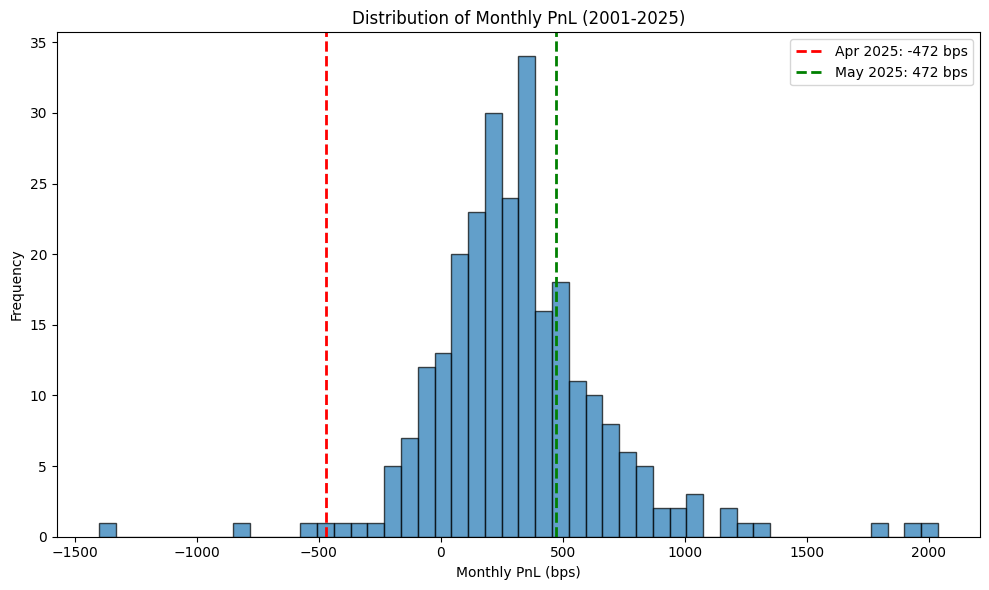

In [6]:
import matplotlib.pyplot as plt

# Compute monthly total PnL over entire period (in leveraged bps)
monthly_total = df.resample('ME').sum().sum(axis=1) * 10000 * 2

# Remove zero months (no trading activity)
monthly_total = monthly_total[monthly_total != 0]

# Get Apr and May 2025 values (extract scalar from Series)
apr_2025 = float(monthly_total['2025-04'].iloc[0])
may_2025 = float(monthly_total['2025-05'].iloc[0])

# Create histogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(monthly_total, bins=50, edgecolor='black', alpha=0.7)

# Add vertical lines for Apr and May 2025
ax.axvline(apr_2025, color='red', linestyle='--', linewidth=2, label=f'Apr 2025: {apr_2025:.0f} bps')
ax.axvline(may_2025, color='green', linestyle='--', linewidth=2, label=f'May 2025: {may_2025:.0f} bps')

ax.set_xlabel('Monthly PnL (bps)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Monthly PnL (2001-2025)')
ax.legend()
plt.tight_layout()
plt.show()

In [7]:
# Find months with PnL < -100 bps and compute forward returns
import warnings
threshold = -100

# Get losing months
losing_months = monthly_total[monthly_total < threshold]

# Compute monthly PnL by asset (full series, not filtered)
monthly_by_asset = df.resample('ME').sum() * 10000 * 2  # leveraged bps per asset
monthly_total_full = monthly_by_asset.sum(axis=1)  # full series with zeros

# Build table
rows = []
for date in losing_months.index:
    month_str = date.strftime('%b%Y')
    loss = monthly_total.loc[date]
    
    # Get position in the FULL series (not filtered)
    pos = monthly_by_asset.index.get_loc(date)
    
    # Top 3 largest losers (most negative) for this month
    loss_month_by_asset = monthly_by_asset.iloc[pos]
    top3_losses = loss_month_by_asset.nsmallest(3).sum()
    
    # Next 1 month
    if pos + 1 < len(monthly_by_asset):
        next_1m = monthly_total_full.iloc[pos + 1]
    else:
        next_1m = np.nan
    
    # Next 2 months cumulative
    if pos + 2 < len(monthly_by_asset):
        next_2m = monthly_total_full.iloc[pos + 1:pos + 3].sum()
    else:
        next_2m = np.nan
    
    # Next 3 months cumulative
    if pos + 3 < len(monthly_by_asset):
        next_3m = monthly_total_full.iloc[pos + 1:pos + 4].sum()
    else:
        next_3m = np.nan
    
    # Total: loss + next 3 months (net PnL after recovery period)
    total_3m = loss + next_3m if not np.isnan(next_3m) else np.nan
    
    # Helper to compute cross-sectional correlation
    def xs_corr(x_by_asset, y_by_asset):
        valid_mask = x_by_asset.notna() & y_by_asset.notna()
        if valid_mask.sum() > 2:
            x = x_by_asset[valid_mask].values
            y = y_by_asset[valid_mask].values
            if x.std() > 1e-10 and y.std() > 1e-10:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    return np.corrcoef(x, y)[0, 1]
        return np.nan
    
    # Cross-sectional correlations: asset PnL in losing month vs forward periods
    cor_1m = np.nan
    cor_2m = np.nan
    cor_3m = np.nan
    
    if pos + 1 < len(monthly_by_asset):
        next_1m_by_asset = monthly_by_asset.iloc[pos + 1]
        cor_1m = xs_corr(loss_month_by_asset, next_1m_by_asset)
    
    if pos + 2 < len(monthly_by_asset):
        next_2m_by_asset = monthly_by_asset.iloc[pos + 1:pos + 3].sum()
        cor_2m = xs_corr(loss_month_by_asset, next_2m_by_asset)
    
    if pos + 3 < len(monthly_by_asset):
        next_3m_by_asset = monthly_by_asset.iloc[pos + 1:pos + 4].sum()
        cor_3m = xs_corr(loss_month_by_asset, next_3m_by_asset)
    
    rows.append({
        'month': month_str,
        'loss': int(round(loss)),
        'top3': int(round(top3_losses)),
        '+1m': int(round(next_1m)) if pd.notna(next_1m) else None,
        '+2m': int(round(next_2m)) if pd.notna(next_2m) else None,
        '+3m': int(round(next_3m)) if pd.notna(next_3m) else None,
        'tot+3m': int(round(total_3m)) if pd.notna(total_3m) else None,
        'c+1m': round(cor_1m * 100, 1) if pd.notna(cor_1m) else None,
        'c+2m': round(cor_2m * 100, 1) if pd.notna(cor_2m) else None,
        'c+3m': round(cor_3m * 100, 1) if pd.notna(cor_3m) else None
    })

loss_table = pd.DataFrame(rows)
loss_table.set_index('month', inplace=True)

print("Losing Months Analysis (threshold: -100 bps)")
print("=" * 60)
loss_table

Losing Months Analysis (threshold: -100 bps)


,loss,top3,+1m,+2m,+3m,tot+3m,c+1m,c+2m,c+3m
month,,,,,,,,,
May2006,-530,-415,124,390,623,92,-13.1,-18.4,-35.9
Jun2007,-158,-301,-68,-96,386,228,22.2,32.4,51.9
Mar2008,-302,-384,42,125,286,-16,-19.5,-20.1,-18.4
Oct2008,-257,-457,1223,2527,4566,4309,-30.2,-46.9,-46.0
May2010,-412,-394,1041,1779,2279,1867,-28.9,-36.2,-44.6
Jan2011,-121,-298,384,1107,1350,1229,39.6,29.2,45.0
May2012,-217,-300,245,1078,1682,1465,31.9,29.1,15.8
Mar2013,-111,-202,480,918,1481,1370,-38.4,-38.7,-39.4
Jan2015,-1403,-3066,-88,-140,66,-1337,-25.7,-36.3,-27.7


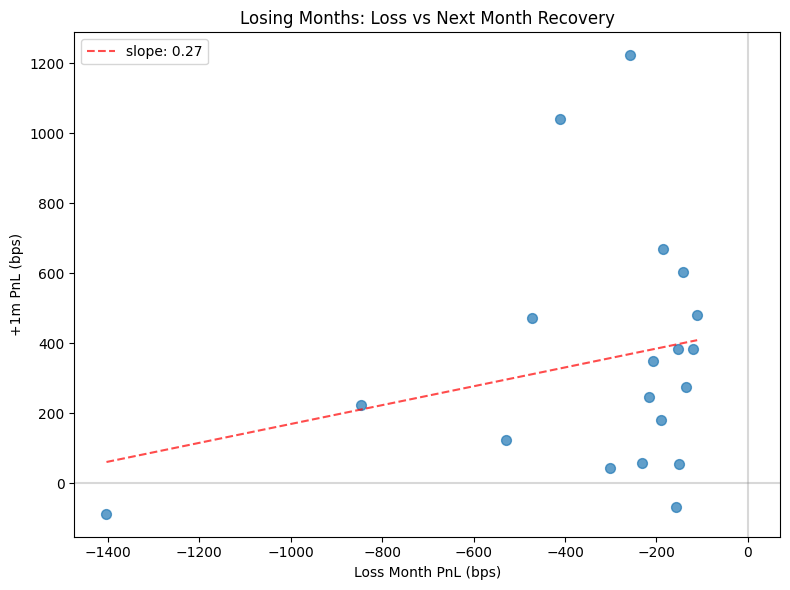

In [8]:
# Scatter plot: Loss month vs +1m recovery
fig, ax = plt.subplots(figsize=(8, 6))

x = loss_table['loss'].values
y = loss_table['+1m'].values

ax.scatter(x, y, s=50, alpha=0.7)

# Add regression line
mask = ~np.isnan(y)
if mask.sum() > 1:
    z = np.polyfit(x[mask], y[mask], 1)
    p = np.poly1d(z)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, p(x_line), 'r--', alpha=0.7, label=f'slope: {z[0]:.2f}')

# Add zero lines
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.axvline(0, color='gray', linestyle='-', alpha=0.3)

ax.set_xlabel('Loss Month PnL (bps)')
ax.set_ylabel('+1m PnL (bps)')
ax.set_title('Losing Months: Loss vs Next Month Recovery')
ax.legend()
plt.tight_layout()
plt.show()

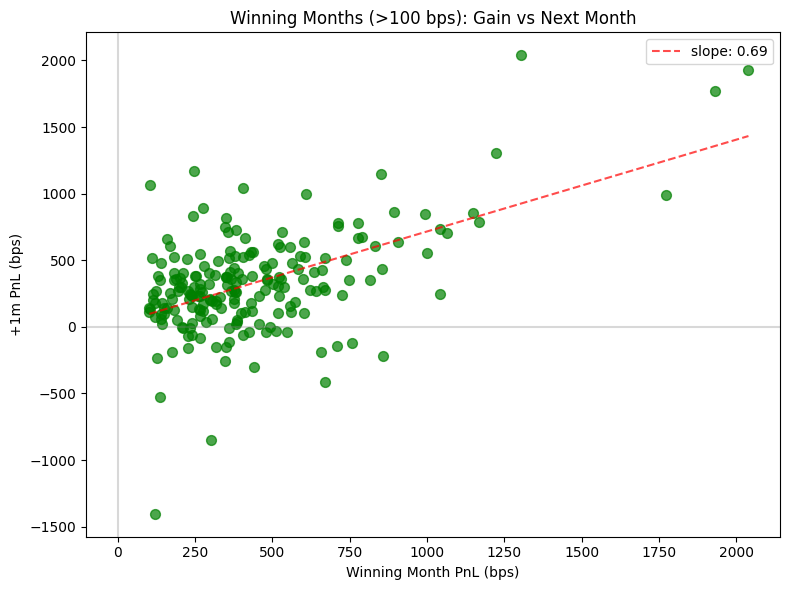

In [9]:
# Winning months analysis (> +100 bps)
winning_threshold = 100
winning_months = monthly_total[monthly_total > winning_threshold]

# Build table for winning months
win_rows = []
for date in winning_months.index:
    month_str = date.strftime('%b%Y')
    gain = monthly_total.loc[date]
    pos = monthly_by_asset.index.get_loc(date)
    
    # Next 1 month
    if pos + 1 < len(monthly_by_asset):
        next_1m = monthly_total_full.iloc[pos + 1]
    else:
        next_1m = np.nan
    
    win_rows.append({
        'month': month_str,
        'gain': int(round(gain)),
        '+1m': int(round(next_1m)) if pd.notna(next_1m) else None,
    })

win_table = pd.DataFrame(win_rows)

# Scatter plot: Winning month vs +1m
fig, ax = plt.subplots(figsize=(8, 6))

x = win_table['gain'].values
y = win_table['+1m'].values

ax.scatter(x, y, s=50, alpha=0.7, color='green')

# Add regression line
mask = ~pd.isna(y)
if mask.sum() > 1:
    z = np.polyfit(x[mask], y[mask], 1)
    p = np.poly1d(z)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, p(x_line), 'r--', alpha=0.7, label=f'slope: {z[0]:.2f}')

# Add zero lines
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.axvline(0, color='gray', linestyle='-', alpha=0.3)

ax.set_xlabel('Winning Month PnL (bps)')
ax.set_ylabel('+1m PnL (bps)')
ax.set_title('Winning Months (>100 bps): Gain vs Next Month')
ax.legend()
plt.tight_layout()
plt.show()